# Project 1: Classification Analysis on Textual Data

**Authors**
* Zhiyuan Chen, chen0error@g.ucla.edu
* Ranjana Vittal, ranjanavittal@g.ucla.edu
* Krish Kabra, krish97@g.ucla.edu

In [9]:
import sys
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
import pandas as pd
import random
random.seed(42)
import nltk, string
nltk.download('all')

runningOnColab = 'google.colab' in sys.modules
if runningOnColab:
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)
  !pip install umap-learn[plot]
  !pip install holoviews
  !pip install -U ipykernel
  # Please link EE 219 folder to your personal drive directory under the following path
  %cd '/content/drive/My Drive/Colab Notebooks/EE 219/Project 1' 
  %ls
  nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /Users/zhiyuanchen/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /Users/zhiyuanchen/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /Users/zhiyuanchen/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to
[nltk_data]    |     /Users/zhiyuanchen/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to
[nltk_data]    |     /Users/zhiyuanchen/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to
[nltk_data]    |     /Users/zhiyuanchen/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloadin

## Getting familiar with the dataset 

In [10]:
from sklearn.datasets import fetch_20newsgroups

### Question 1: Visualizing the dataset
Plot a histogram of the number of training documents for each of the 20 categories to check if they are evenly distributed.

In [11]:
twenty_train = fetch_20newsgroups(subset='train', 
                                  categories=None, 
                                  shuffle=True,
                                  random_state=42, 
                                 )

In [12]:
all_categories=twenty_train.target_names
num_in_categories=[]

for category in all_categories:
  temp_train = fetch_20newsgroups(subset='train', 
                                  categories=[category], 
                                  shuffle=True,
                                  random_state=42, 
                                 )
  num_in_categories.append(len(temp_train.data))  

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 <a list of 20 Text xticklabel objects>)

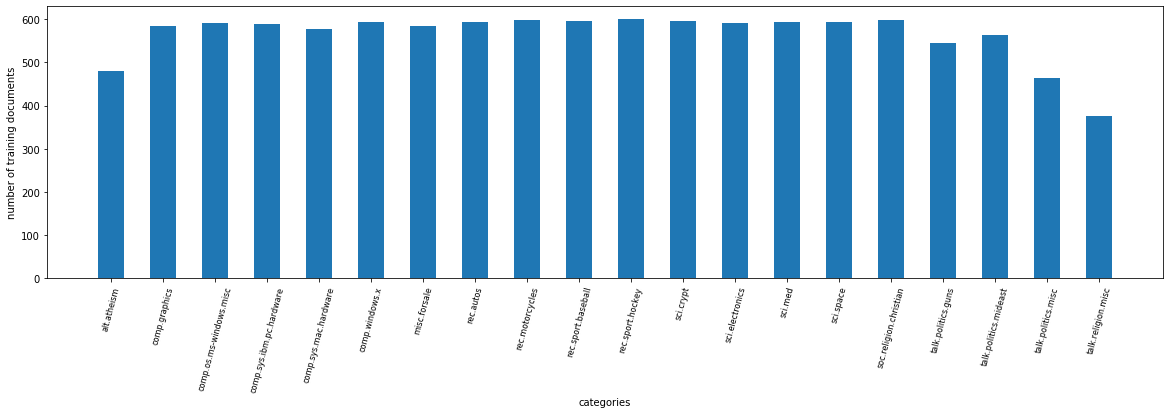

In [13]:
import matplotlib.pyplot as plt

x=all_categories
y=num_in_categories

plt.figure(figsize=(20, 5))
plt.bar(x,y,width=0.5)
plt.xlabel('categories')
plt.ylabel('number of training documents')
plt.xticks(rotation = (75), fontsize = 8, va='top', ha='center') 

## Binary Classification

### Question 2: Feature extraction

In [14]:
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from sklearn.feature_extraction.text import TfidfVectorizer

def pennmorphy(penntag):
    morphytag = {'NN':'n', 'JJ':'a','VB':'v', 'RB':'r'}
    try:
        return morphytag[penntag[:2]]
    except:
        return 'n'

def lemmatize_sent(text):
    lem = WordNetLemmatizer()
    return [lem.lemmatize(word.lower(), pos=pennmorphy(tag)) for word, tag in pos_tag(nltk.word_tokenize(text))]

def lemmatize_dataset(dataset):
  for n,lemsent in enumerate(dataset.data):
    lemsent = lemmatize_sent(lemsent) # lemmatize
    lemsent = [i for i in lemsent if i not in string.punctuation] # remove punctuation
    lemsent = [i for i in lemsent if not i.isdigit()] # remove numbers
    dataset.data[n] = " ".join(lemsent)  
  return dataset

categories = ['comp.graphics', 'comp.os.ms-windows.misc','comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware','rec.autos', 'rec.motorcycles','rec.sport.baseball', 'rec.sport.hockey']

traindataset = fetch_20newsgroups(subset = 'train', categories = categories, shuffle = True, random_state = 42)# getting training data
traindataset = lemmatize_dataset(traindataset)

# for n,lemsent in enumerate(traindataset.data):
#     lemsent = lemmatize_sent(lemsent) # lemmatize
#     lemsent = [i for i in lemsent if i not in string.punctuation] # remove punctuation
#     lemsent = [i for i in lemsent if not i.isdigit()] # remove numbers
#     traindataset.data[n] = " ".join(lemsent)

testdataset = fetch_20newsgroups(subset = 'test', categories = categories, shuffle = True, random_state = 42) # getting test data
testdataset = lemmatize_dataset(testdataset)
# for n,lemsent in enumerate(testdataset.data):
#     lemsent = lemmatize_sent(lemsent) # lemmatize
#     lemsent = [i for i in lemsent if i not in string.punctuation] # remove punctuation
#     lemsent = [i for i in lemsent if not i.isdigit()] # remove numbers
#     testdataset.data[n] = " ".join(lemsent)

tfi_vect = TfidfVectorizer(stop_words='english',min_df=3)

XTrain_tfi = tfi_vect.fit_transform(traindataset.data) # making the tfidf train matrix
print("Shape of TF-IDF train matrix: ", XTrain_tfi.shape)

XTest_tfi = tfi_vect.transform(testdataset.data) # transforming the test data into the tfidf test matrix
print("Shape of TF-IDF test matrix: ", XTest_tfi.shape)

Shape of TF-IDF train matrix:  (4732, 17671)
Shape of TF-IDF test matrix:  (3150, 17671)


### Question 3: Dimensionality reduction

In [15]:
from sklearn.decomposition import TruncatedSVD
from sklearn.utils.extmath import randomized_svd
from sklearn.decomposition import NMF

lsi = TruncatedSVD(n_components=50, random_state=42)
XTrain_lsi = lsi.fit_transform(XTrain_tfi) # performing LSI on the tfidf train matrix
XTest_lsi = lsi.transform(XTest_tfi) # performing LSI on the tfidf test matrix
U,Sigm,VT = randomized_svd(XTrain_tfi,n_components=50,random_state=42) # obtaining the left singular matrix, singular values and right singular matrix
Sigm = np.diag(Sigm)
print("Error for LSI: ", np.sum(np.array(XTrain_tfi - U.dot(Sigm).dot(VT))**2))


nmf = NMF(n_components=50, init='random', random_state=42)
XTrain_nmf = nmf.fit_transform(XTrain_tfi) # performing NMF on the tfidf train matrix
XTest_nmf = nmf.transform(XTest_tfi) # performing NMF on the tfidf test matrix
H = nmf.components_
print("Error for NMF: ", np.sum(np.array(XTrain_tfi - XTrain_nmf.dot(H))**2))

Error for LSI:  4116.558613022112
Error for NMF:  4154.183349689949


### Question 4: Support Vector Machines

In [16]:
# Classification metrics tools 
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_curve, auc
import itertools

def plotconfusion_matrix(confm, classes, normalize=False, title='Confusion matrix', cmap_name='Blues'):
    if normalize:
        confm = confm.astype('float') / confm.sum(axis=1)[:, np.newaxis]
    plt.imshow(confm, interpolation='nearest', cmap=plt.get_cmap(cmap_name))
    plt.title(title)
    plt.colorbar()
    tickmarks = np.arange(len(classes))
    plt.xticks(tickmarks, classes, rotation=65)
    plt.yticks(tickmarks, classes)
    scl = '.2f' if normalize else 'd'
    thresh = confm.max() / 2.
    for i, j in itertools.product(range(confm.shape[0]), range(confm.shape[1])):
        plt.text(j, i, format(confm[i, j], scl),horizontalalignment="center",color="white" if confm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def classifier_metrics(ytest,ypred,name="",average='binary'):
    print("Accuracy score for %s: %f" %(name,accuracy_score(ytest,ypred)))
    print("Recall score for %s: %f" % (name,recall_score(ytest,ypred,average=average)))
    print("Precision score for %s: %f" % (name,precision_score(ytest,ypred,average=average)))
    print("F-1 score for %s: %f" % (name,f1_score(ytest,ypred,average=average)))

def plotroc_curve(ytest,decision_function,name=""):
    falsepr = dict()
    truepr = dict()
    rocauc = dict()
    falsepr, truepr, thresholds = roc_curve(ytest, decision_function)
    rocauc = auc(falsepr, truepr)
    plt.figure()
    lw = 2
    plt.plot(falsepr, truepr, color='darkorange',lw=lw, label='ROC curve (area = %0.4f)' % rocauc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate');
    plt.title('%s ROC curve' % name);plt.legend(loc="lower right")



/Users/zhiyuanchen/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy score for Hard Margin SVM: 0.971111
Recall score for Hard Margin SVM: 0.976101
Precision score for Hard Margin SVM: 0.966978
F-1 score for Hard Margin SVM: 0.971518
Accuracy score for Soft Margin SVM: 0.667302
Recall score for Soft Margin SVM: 1.000000
Precision score for Soft Margin SVM: 0.602729
F-1 score for Soft Margin SVM: 0.752129


/Users/zhiyuanchen/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/zhiyuanchen/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/zhiyuanchen/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/zhiyuanchen/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/zhiyuanchen/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to c

Grid search results for SVM:  {'mean_fit_time': array([0.00793839, 0.00941849, 0.01025805, 0.01420808, 0.04132795,
       0.24556751, 0.65105495]), 'std_fit_time': array([0.00089456, 0.00107674, 0.0013434 , 0.00135811, 0.00153936,
       0.04744834, 0.00775474]), 'mean_score_time': array([0.00061998, 0.00071921, 0.00062847, 0.00066438, 0.00069504,
       0.00075274, 0.00103378]), 'std_score_time': array([1.01871614e-04, 1.66845151e-04, 1.03522874e-04, 1.24956321e-04,
       4.92887729e-05, 6.87450361e-05, 6.70649045e-05]), 'param_C': masked_array(data=[0.001, 0.01, 0.1, 1, 10, 100, 1000],
             mask=[False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 0.001}, {'C': 0.01}, {'C': 0.1}, {'C': 1}, {'C': 10}, {'C': 100}, {'C': 1000}], 'split0_test_score': array([0.94825766, 0.97148891, 0.97571278, 0.97465681, 0.97782471,
       0.97676874, 0.97571278]), 'split1_test_score': array([0.93664203, 0.96726505, 0.97360084, 0.9

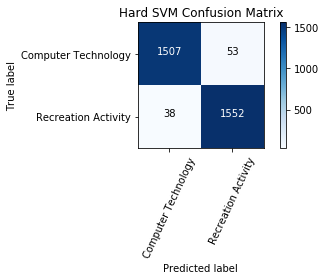

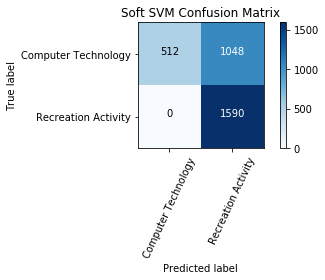

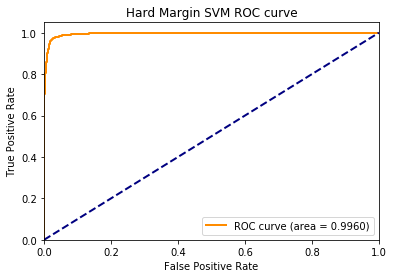

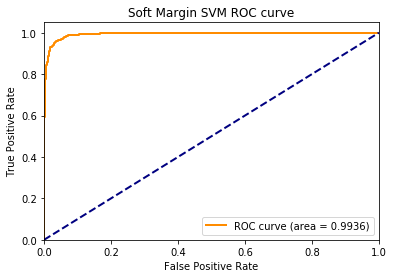

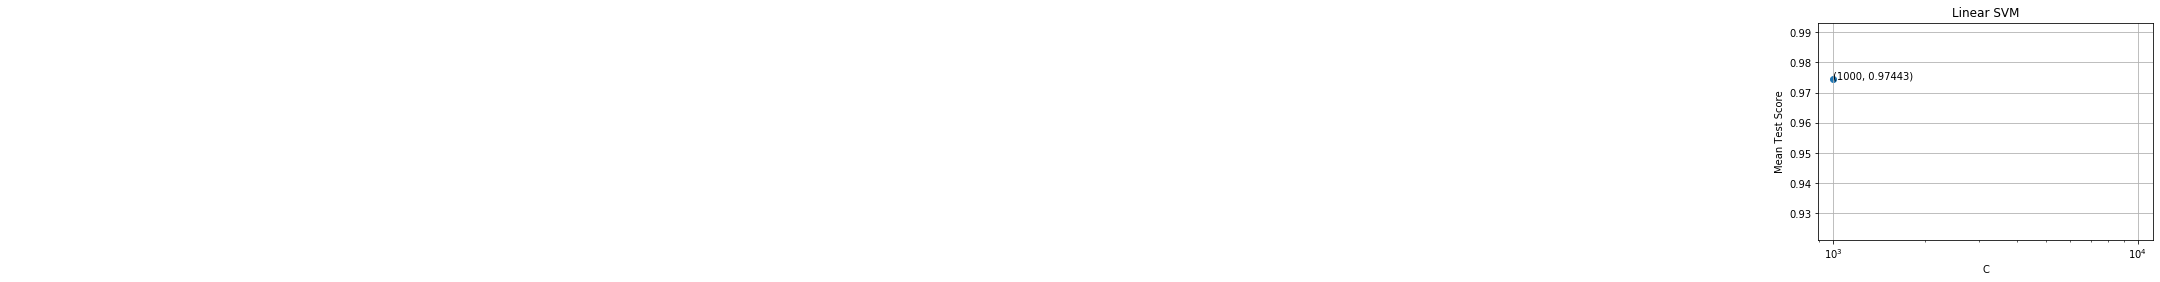

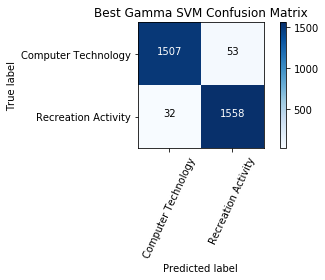

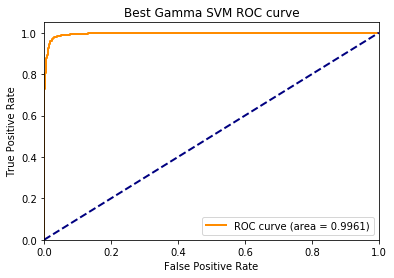

In [17]:
# SVM 
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

hardSVM = LinearSVC(C=1000,random_state=42,max_iter=10000)
softSVM = LinearSVC(C=0.0001,random_state=42,max_iter=10000)

ytrain = [int(i/4) for i in traindataset.target] # making the train labels compatible for binary classification
ytest = [int(i/4) for i in testdataset.target] # making the test labels compatible for binary classification

ypred_hard = hardSVM.fit(XTrain_lsi,ytrain).predict(XTest_lsi) # predicting labels for hard margin SVM
ypred_soft = softSVM.fit(XTrain_lsi,ytrain).predict(XTest_lsi) # predicting labels for soft margin SVM

classifier_metrics(ytest,ypred_hard,name="Hard Margin SVM")
classifier_metrics(ytest,ypred_soft,name="Soft Margin SVM")

classnames = ['Computer Technology', 'Recreation Activity']
hard_confm = confusion_matrix(ytest,ypred_hard) # Hard SVM Confusion matrix
plt.figure()
plotconfusion_matrix(hard_confm, classes=classnames, title='Hard SVM Confusion Matrix') 
soft_confm = confusion_matrix(ytest,ypred_soft) # Soft SVM Confusion matrix
plt.figure()
plotconfusion_matrix(soft_confm, classes=classnames, title='Soft SVM Confusion Matrix')

plotroc_curve(ytest,hardSVM.decision_function(XTest_lsi),name="Hard Margin SVM") # Hard SVM ROC curve 
plotroc_curve(ytest,softSVM.decision_function(XTest_lsi),name="Soft Margin SVM") # Soft SVM ROC curve 

lsvc = LinearSVC(random_state=42,max_iter=10000) 
params = {'C':[0.001,0.01,0.1,1,10,100,1000]}
crof = GridSearchCV(lsvc,params,cv=5,scoring='accuracy') # Finding the best gamma using cross validation
crof.fit(XTrain_lsi,ytrain)

x = [0.001,0.01,0.1,1,10,100,1000]
y = crof.cv_results_['mean_test_score']
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(x,y)
for xy in zip(x, y):                                       
    ax.annotate('(%s, %.5f)' % xy, xy=xy, textcoords='data')
plt.xlabel('C')
plt.ylabel('Mean Test Score')
plt.title("Linear SVM")
plt.grid()
ax.set_xscale('log')

ypred_cv = crof.best_estimator_.predict(XTest_lsi)
bestsvm_gamma = crof.best_estimator_.C

print("Grid search results for SVM: ", crof.cv_results_)
print("Best estimator for SVM: ", crof.best_estimator_)
print("Best parameters for SVM: ", crof.best_params_)
print("Best score for SVM: ", crof.best_score_)
print("Best Gamma for SVM: ", bestsvm_gamma)
classifier_metrics(ytest,ypred_cv,name="Best Gamma SVM")

cv_confm = confusion_matrix(ytest,ypred_cv) # Best Gamma SVM confusion matrix
plt.figure()
plotconfusion_matrix(cv_confm, classes=classnames, title='Best Gamma SVM Confusion Matrix')

plotroc_curve(ytest,crof.best_estimator_.decision_function(XTest_lsi),name="Best Gamma SVM") # Best Gamma SVM ROC curve 

### Question 5: Logistic classification

Coefficients learned by logistic regression without regularization:  [[-4.53667893e+00  1.25127777e+02 -2.03066916e+01  9.49725040e+01
   1.13794764e+01 -2.28288805e+01  1.90876843e+00 -6.99778470e-01
   2.74971012e+01  7.02990346e+00  3.42602084e+01 -7.15543198e+00
  -1.30766281e+01  1.15303862e+01  4.48896329e+00 -1.33650968e+01
  -1.01287155e+01  1.00092849e+01  1.69717875e+01 -1.32179384e+01
   6.76214499e+00  6.04824620e+00 -1.03830768e+01  2.79938551e+00
  -1.74837107e+01  7.81817246e+00 -2.36227077e+00 -8.64533120e-01
   2.50667038e+01  2.54000959e-01 -9.98398866e-02  1.42028892e+01
   1.21868642e+01  1.91780843e-01  9.07479401e+00 -1.14805788e+00
   2.98008895e+00 -1.41212646e+01  5.14143921e+00  4.84792276e+00
   1.02707289e+01  1.81715134e+01  5.12975797e+00  3.95643952e+00
   7.96528806e+00  7.08422098e+00  1.45986022e+00 -4.00984113e+00
  -1.04791380e+01 -1.11352516e+01]]
Accuracy score for Logistic Regression without regularization: 0.971111
Recall score for Logistic Regre

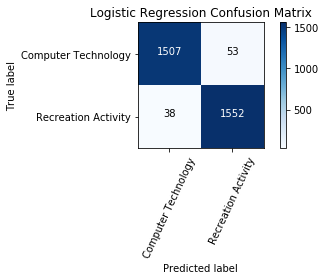

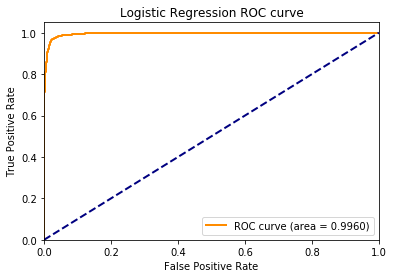

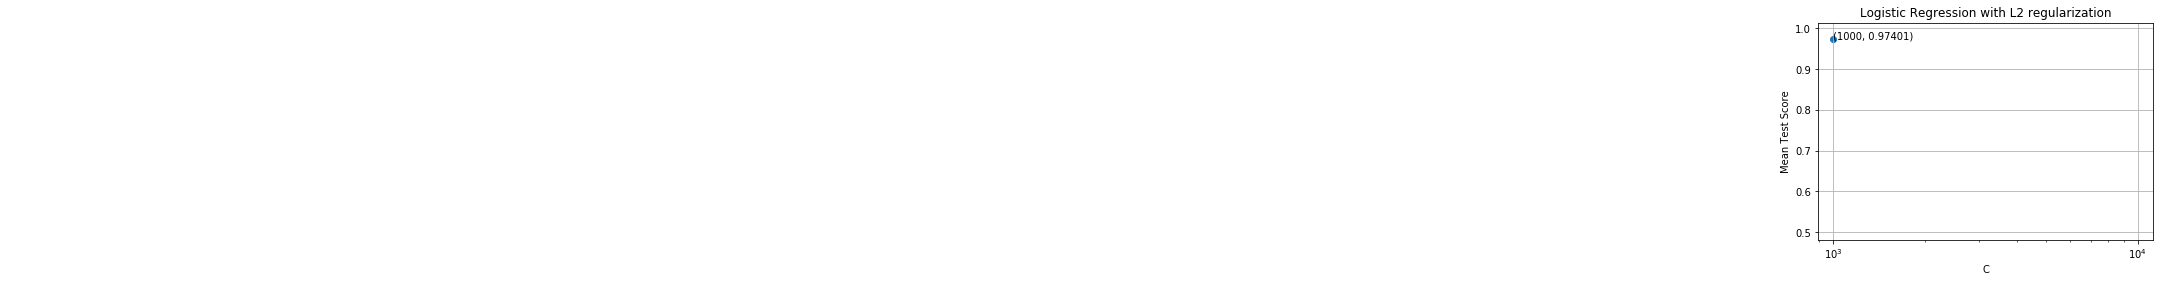

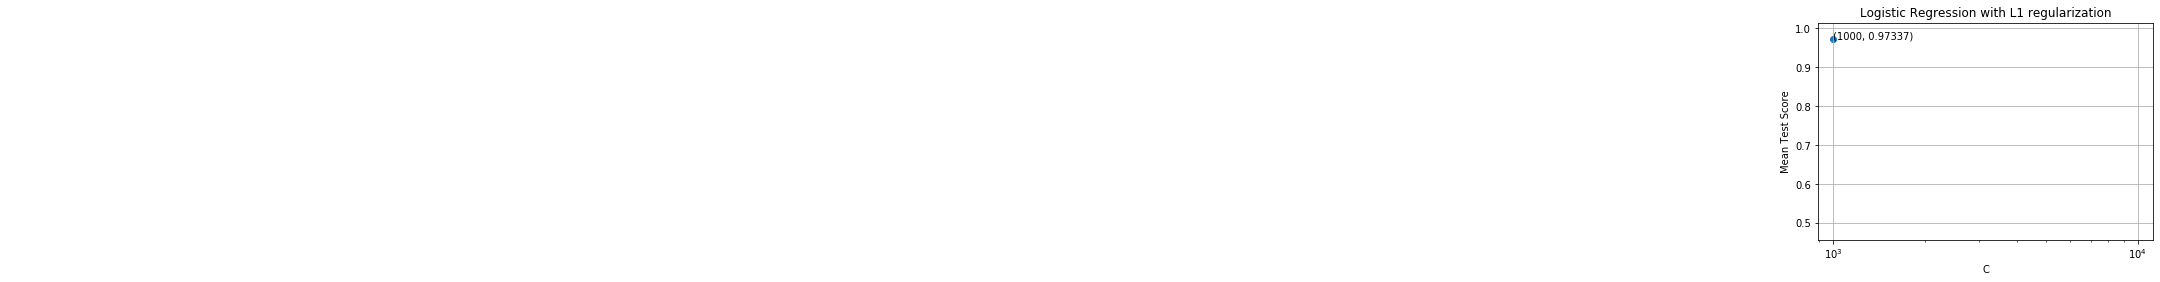

In [18]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C=10**10,random_state=42,max_iter=10000) # Logistic regression without regularization
ypred_logreg = logreg.fit(XTrain_lsi,ytrain).predict(XTest_lsi)
print("Coefficients learned by logistic regression without regularization: ", logreg.coef_)
classifier_metrics(ytest,ypred_logreg,name="Logistic Regression without regularization")
logreg_confm = confusion_matrix(ytest,ypred_logreg) # logistic regression without regularization confusion matrix
plt.figure()
plotconfusion_matrix(logreg_confm, classes=classnames, title='Logistic Regression Confusion Matrix')
plotroc_curve(ytest,logreg.decision_function(XTest_lsi),name="Logistic Regression") # logistic regression without regularization roc curve

logreg_L2 = LogisticRegression(random_state=42,max_iter=10000) # logistic regression with L2 regularization
clasf_L2 = GridSearchCV(logreg_L2,params,cv=5,scoring='accuracy') # grid search for best gamma for L2 regularization
ypred_L2 = clasf_L2.fit(XTrain_lsi,ytrain).best_estimator_.predict(XTest_lsi)
bestL2_gamma = clasf_L2.best_estimator_.C

x = [0.001,0.01,0.1,1,10,100,1000]
y = clasf_L2.cv_results_['mean_test_score']
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(x,y)
for xy in zip(x, y):                                       
    ax.annotate('(%s, %.5f)' % xy, xy=xy, textcoords='data')
plt.xlabel('C')
plt.ylabel('Mean Test Score')
plt.title("Logistic Regression with L2 regularization")
plt.grid()
ax.set_xscale('log')

print("Grid search results for logistic regression with L-2 regularization: ", clasf_L2.cv_results_)
print("Best estimator for logistic regression with L-2 regularization: ", clasf_L2.best_estimator_)
print("Best parameters for logistic regression with L-2 regularization: ", clasf_L2.best_params_)
print("Best score for logistic regression with L-2 regularization: ", clasf_L2.best_score_)
print("Best Gamma for logistic regression with L-2 regularization: ", bestL2_gamma)
print("Coefficients learned by logistic regression with L-2 regularization: ", clasf_L2.best_estimator_.coef_)
classifier_metrics(ytest,ypred_L2,name="Logistic Regression with L-2 regularization")

logreg_L1 = LogisticRegression(penalty='l1',solver='liblinear',random_state=42,max_iter=10000) # logistic regression with L1 regularization
clasf_L1 = GridSearchCV(logreg_L1,params,cv=5,scoring='accuracy') # grid search for best gamma for L1 regularization
ypred_L1 = clasf_L1.fit(XTrain_lsi,ytrain).best_estimator_.predict(XTest_lsi)
bestL1_gamma = clasf_L1.best_estimator_.C

x = [0.001,0.01,0.1,1,10,100,1000]
y = clasf_L1.cv_results_['mean_test_score']
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(x,y)
for xy in zip(x, y):                                       
    ax.annotate('(%s, %.5f)' % xy, xy=xy, textcoords='data')
plt.xlabel('C')
plt.ylabel('Mean Test Score')
plt.title("Logistic Regression with L1 regularization")
plt.grid()
ax.set_xscale('log')

print("Grid search results for logistic regression with L-1 regularization: ", clasf_L1.cv_results_)
print("Best estimator for logistic regression with L-1 regularization: ", clasf_L1.best_estimator_)
print("Best parameters for logistic regression with L-1 regularization: ", clasf_L1.best_params_)
print("Best score for logistic regression with L-1 regularization: ", clasf_L1.best_score_)
print("Best Gamma for logistic regression with L-1 regularization: ", bestL1_gamma)
print("Coefficients learned by logistic regression with L-1 regularization: ", clasf_L1.best_estimator_.coef_)
classifier_metrics(ytest,ypred_L1,name="Logistic Regression with L-1 regularization")


### Question 6: Naive Bayes classification

Accuracy score for Gaussian Naive Bayes: 0.895238
Recall score for Gaussian Naive Bayes: 0.972956
Precision score for Gaussian Naive Bayes: 0.843511
F-1 score for Gaussian Naive Bayes: 0.903621


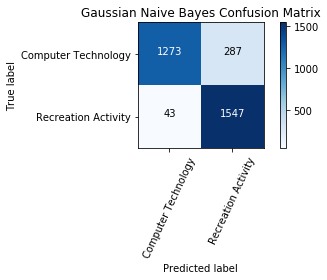

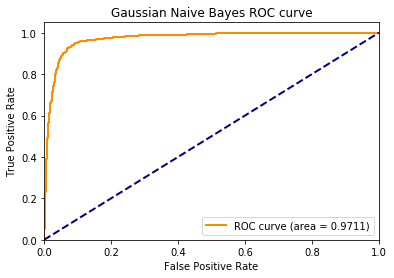

In [19]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
ypred_nb = clf.fit(XTrain_lsi, ytrain).predict(XTest_lsi)
classifier_metrics(ytest,ypred_nb,name="Gaussian Naive Bayes")
nb_confm = confusion_matrix(ytest,ypred_nb)
plt.figure()
plotconfusion_matrix(nb_confm, classes=classnames, title='Gaussian Naive Bayes Confusion Matrix')
plotroc_curve(ytest,clf.predict_proba(XTest_lsi)[:,1],name="Gaussian Naive Bayes")

### Question 7: Grid search of parameters

In [21]:
from sklearn.base import BaseEstimator, TransformerMixin

# Lemmatize dataset Transformer for Pipeline
class Lemmatize(BaseEstimator, TransformerMixin): 
  def __init__(self, use_lem=True): 
    self.use_lem = use_lem

  def fit(self, X, y=None):
    return self    
    
  def transform(self, X):
    X_ = X.copy()
    if self.use_lem: 
      for n,lemsent in enumerate(X_):
        lemsent = self._lemmatize_sent(lemsent) # lemmatize
        lemsent = [i for i in lemsent if i not in string.punctuation] # remove punctuation
        lemsent = [i for i in lemsent if not i.isdigit()] # remove numbers
        X_[n] = " ".join(lemsent)
      return X_
    else: 
      return X_

  def _lemmatize_sent(self,text):
    lem = WordNetLemmatizer()
    return [lem.lemmatize(word.lower(), pos=pennmorphy(tag)) for word, tag in pos_tag(nltk.word_tokenize(text))]  

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from pprint import pprint
from time import time

# Create Pipeline 
pipeline = Pipeline([
    ('lem', Lemmatize()), 
    ('vect', TfidfVectorizer(stop_words='english')),
    ('reduce_dim', 'passthrough'),
    ('clf', 'passthrough'),
])

# dimensionality reduction options 
lsi = TruncatedSVD(n_components=50, random_state=42)
nmf = NMF(n_components=50, init='random', random_state=42)

#classifier options
bestgamma_svm=LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=0)

bestL2_logreg=LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

bestL1_logreg=LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

# parameters to search
parameters = {
    'lem__use_lem': (True, False), 
    'vect__min_df': (3,5), #two underscore lines for parameter within a parameter
    'reduce_dim': [lsi, nmf],
    'clf':[bestgamma_svm, bestL2_logreg, bestL1_logreg, GaussianNB()]
}

# Establish two different datasets with and without headers & footers
categories = ['comp.graphics', 'comp.os.ms-windows.misc','comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware','rec.autos', 'rec.motorcycles','rec.sport.baseball', 'rec.sport.hockey']

traindataset = fetch_20newsgroups(subset = 'train', categories = categories, shuffle = True, random_state = 42)# getting training data
testdataset = fetch_20newsgroups(subset = 'test', categories = categories, shuffle = True, random_state = 42) # getting test data

traindataset_removeHF = fetch_20newsgroups(subset = 'train', categories = categories, shuffle = True, random_state = 42, remove=('headers', 'footers'))# getting training data
testdataset_removeHF = fetch_20newsgroups(subset = 'test', categories = categories, shuffle = True, random_state = 42, remove=('headers', 'footers')) # getting test data

# Perform grid search 
grid_search = GridSearchCV(pipeline,parameters,cv=5,scoring='accuracy',n_jobs=-1,verbose=1)

print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters)

print("Performing grid search WITH headers and footers...")

t0 = time()
grid_search.fit(testdataset.data, testdataset.target)

print("done in %0.3f secs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

#ypred_cv = grid_search.best_estimator_.predict(testdataset.data)
#classifier_metrics(testdataset.target,ypred_cv,name="Best method with headers & footers")

#cv_confm = confusion_matrix(testdataset.target,ypred_cv) # Best Gamma SVM confusion matrix
#plt.figure()
#plotconfusion_matrix(cv_confm, classes=classnames, title='Best method with headers & footers Confusion Matrix') # Best confusion matrix 

#plotroc_curve(ytest,crof.best_estimator_.decision_function(XTest_lsi),name="Best method with headers & footers") # Best ROC curve 

print('======================================================')
print("Performing grid search WITHOUT headers and footers...")

t0 = time()
grid_search.fit(testdataset_removeHF.data, testdataset_removeHF.target)

print("done in %0.3f secs" % (time() - t0))

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

#ypred_cv = grid_search.best_estimator_.predict(testdataset_removeHF.data)
#classifier_metrics(testdataset_removeHF.target,ypred_cv,name="Best method without headers & footers")

#cv_confm = confusion_matrix(testdataset_removeHF.target,ypred_cv) # Best Gamma SVM confusion matrix
#plt.figure()
#plotconfusion_matrix(cv_confm, classes=classnames, title='Best method without headers & footers Confusion Matrix') # Best confusion matrix 

#plotroc_curve(ytest,crof.best_estimator_.decision_function(XTest_lsi),name="Best method without headers & footers") # Best ROC curve 

pipeline: ['lem', 'vect', 'reduce_dim', 'clf']
parameters:
{'clf': [LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=0),
         LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False),
         LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False),
         GaussianNB(priors=None

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 22.3min finished
/Users/zhiyuanchen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


done in 1382.933 secs

Best score: 0.870
Best parameters set:
	clf: LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
	lem__use_lem: True
	reduce_dim: TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5, random_state=42,
             tol=0.0)
	vect__min_df: 3
Performing grid search WITHOUT headers and footers...
Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 18.2min finished


done in 1131.540 secs
Best score: 0.837
Best parameters set:
	clf: LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
	lem__use_lem: True
	reduce_dim: TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5, random_state=42,
             tol=0.0)
	vect__min_df: 3


/Users/zhiyuanchen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


## Word Embedding

### Question 9: Feature engineering with GLoVE

In [51]:
import os 

import zipfile

with zipfile.ZipFile("/Users/zhiyuanchen/Desktop/project1/glove.6B.zip", "r") as zip_ref:
    zip_ref.extractall()


def load_glove(dim=300): 
  # unzip glove embeddings
  if not os.path.isdir("glove"):
    !unzip "glove.6B.zip" -d "glove/"

  # load glove embeddings as dict
  embeddings_dict = {}
  with open(f"glove/glove.6B.{int(dim)}d.txt", 'r') as f:
    for line in f:
      values = line.split()
      word = values[0]
      vector = np.asarray(values[1:], "float32")
      embeddings_dict[word] = vector
  return embeddings_dict

embeddings_dict = load_glove()
print(f"Computer: {embeddings_dict['computer']}")

Computer: [-2.7628e-01  1.3999e-01  9.8519e-02 -6.4019e-01  3.1988e-02  1.0066e-01
 -1.8673e-01 -3.7129e-01  5.9740e-01 -2.0405e+00  2.2368e-01 -2.6314e-02
  7.2408e-01 -4.3829e-01  4.8886e-01 -3.5486e-03 -1.0006e-01 -3.0587e-01
 -1.5621e-01 -6.8136e-02  2.1104e-01  2.9287e-01 -8.8861e-02 -2.0462e-01
 -5.7602e-01  3.4526e-01  4.1390e-01  1.7917e-01  2.5143e-01 -2.2678e-01
 -1.0103e-01  1.4576e-01  2.0127e-01  3.1810e-01 -7.8907e-01 -2.2194e-01
 -2.4833e-01 -1.5103e-02 -2.0050e-01 -2.6441e-02  1.8551e-01  3.3782e-01
 -3.3543e-01  8.6117e-01 -4.7083e-02 -1.7009e-01  3.0438e-01  9.4119e-02
  3.2435e-01 -8.1171e-01  8.8966e-01 -3.9149e-01  1.6828e-01  1.4316e-01
  3.6339e-03 -6.4557e-02  4.5777e-02 -3.2248e-01  4.8943e-02  1.6817e-01
  6.8344e-02  5.4227e-01  1.2493e-01  6.9742e-01 -3.7194e-02  3.3080e-01
 -4.2194e-01  3.3970e-01  2.7646e-01 -1.6003e-02 -2.1827e-01  4.4535e-01
  3.5379e-01 -2.2089e-02  2.1375e-01  4.3267e-01 -3.2897e-01  9.6165e-02
  3.1265e-01 -3.0528e-01  2.6126e-01 -6.5

In [41]:
# Part a: Feature engineering process with GLoVE
from nltk.corpus import stopwords

def features_from_glove(input_data, embeddings_dict, dim_embedding): 
  """
  Feature engineering process to represent text from documents as vectors using GLoVE word embeddings
  Output features given as the average embedding of words highlighted in text by "Keywords"... or "Subject" headers 
  INPUTS
    input_data: array of strings containing document text, shape = (n_docs,) 
    embedding_dict: dictionary containing GLoVE word embeddings
    dim_embedding: integer value for dimension of GLoVE embedding
  OUTPUTS 
    output: shape = (n_docs,dim_embedding)
  """
  
  n_docs = len(input_data)
  output = np.zeros((n_docs, dim_embedding))
  
  # Loop through every document
  for k,text in enumerate(input_data):  
    
    text_vec = np.zeros(dim_embedding)
   
    # split text by newlines  
    # split text by newlines  
    for line in text.split("\n"): 
      words = line.split()
      bool_topical = False
      # Find important topical words highlighted by "Keywords:" or "Subjects:"
      if 'Keywords:' in words: 
        words.remove('Keywords:')
        bool_topical = True
      elif 'Subject:' in words: 
        words.remove('Subject:')
        bool_topical = True
      # Pre-process words by lemmatizing and removing punctuation and numbers
      if bool_topical: 
        text = ' '.join(words).lower()
        lemsent = lemmatize_sent(text) # lemmatize
        lemsent = [i for i in lemsent if i not in string.punctuation] # remove punctuation 
        lemsent = [i for i in lemsent if not i.isdigit()] # remove numbers 
        # Aggregate words into single vector 
        for word in lemsent: 
          if word in embeddings_dict.keys(): 
            text_vec += embeddings_dict[word]
    # normalize final vec 
    norm = np.sqrt(np.sum(np.square(text_vec)))
    if norm > 0: 
      text_vec /= np.sqrt(np.sum(np.square(text_vec)))

    output[k] = text_vec
  
  return output

dimension_of_glove = 300
embeddings_dict = load_glove(dim=dimension_of_glove)

categories = ['comp.graphics', 'comp.os.ms-windows.misc','comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware','rec.autos', 'rec.motorcycles','rec.sport.baseball', 'rec.sport.hockey']

traindataset = fetch_20newsgroups(subset = 'train', categories = categories, shuffle = True, random_state = 42)# getting training data
XTrain_glove = features_from_glove(traindataset.data, embeddings_dict, dimension_of_glove)
y_train = np.array([int(i/4) for i in traindataset.target]) # making the train labels compatible for binary classification

testdataset = fetch_20newsgroups(subset = 'test', categories = categories, shuffle = True, random_state = 42) # getting test data
XTest_glove = features_from_glove(testdataset.data, embeddings_dict, dimension_of_glove)
y_test = np.array([int(i/4) for i in testdataset.target]) # making the test labels compatible for binary classification

/Users/zhiyuanchen/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/zhiyuanchen/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/zhiyuanchen/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/zhiyuanchen/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/zhiyuanchen/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to c

Grid search results for SVM:  {'mean_fit_time': array([0.0415451 , 0.04527326, 0.04827318, 0.09630013, 0.50539937,
       5.80355325, 7.11045861]), 'std_fit_time': array([0.00798997, 0.00125956, 0.00179351, 0.00651172, 0.09734711,
       0.78469319, 0.14788108]), 'mean_score_time': array([0.00076137, 0.0006732 , 0.00075483, 0.00067143, 0.00082669,
       0.00085921, 0.00091395]), 'std_score_time': array([2.85493505e-04, 5.41561072e-05, 1.24490484e-04, 5.86229350e-05,
       1.44619970e-04, 1.34789003e-04, 9.54906859e-05]), 'param_C': masked_array(data=[0.001, 0.01, 0.1, 1, 10, 100, 1000],
             mask=[False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 0.001}, {'C': 0.01}, {'C': 0.1}, {'C': 1}, {'C': 10}, {'C': 100}, {'C': 1000}], 'split0_test_score': array([0.82893347, 0.87961985, 0.90707497, 0.9250264 , 0.9218585 ,
       0.92397043, 0.90918691]), 'split1_test_score': array([0.81098205, 0.86166843, 0.89757128, 0.9

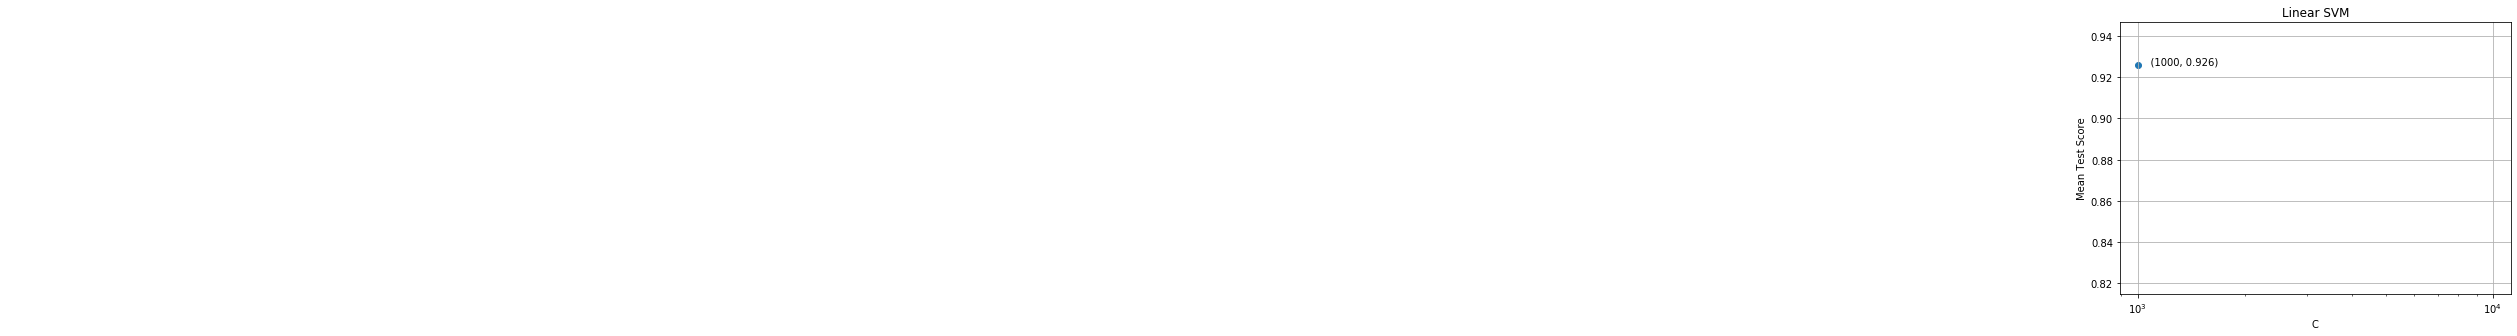

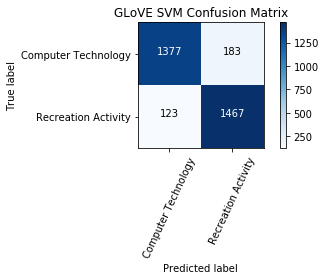

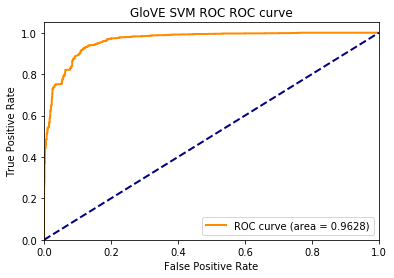

In [42]:
# Part b: Binary classification with SVM 

# Find best params 
lsvc = LinearSVC(random_state=42,max_iter=10000) 
param_list = [0.001,0.01,0.1,1,10,100,1000]
params = {'C':param_list}
crof = GridSearchCV(lsvc,params,cv=5,scoring='accuracy') # Finding the best gamma using cross validation
crof.fit(XTrain_glove,y_train)

x = param_list
y = crof.cv_results_['mean_test_score']
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
plt.scatter(x,y)
for xy in zip(x, y):                                       
    ax.annotate('    (%s, %.3f)' % xy, xy=xy, textcoords='data')
plt.xlabel('C'); plt.ylabel('Mean Test Score'); plt.title("Linear SVM")
plt.grid()
ax.set_xscale('log')

ypred_cv = crof.best_estimator_.predict(XTest_glove)
bestsvm_gamma = crof.best_estimator_.C

print("Grid search results for SVM: ", crof.cv_results_)
print("Best estimator for SVM: ", crof.best_estimator_)
print("Best parameters for SVM: ", crof.best_params_)
print("Best score for SVM: ", crof.best_score_)
print("Best Gamma for SVM: ", bestsvm_gamma)
classifier_metrics(y_test,ypred_cv,name="Best Gamma SVM")

# Best Gamma confusion matrix
cv_confm = confusion_matrix(y_test,ypred_cv) 
plt.figure(); plotconfusion_matrix(cv_confm, classes=classnames, title='GLoVE SVM Confusion Matrix')

plotroc_curve(y_test,crof.best_estimator_.decision_function(XTest_glove),name="GloVE SVM ROC") # Best Gamma SVM ROC curve 

### Question 10: GLoVE results analysis part 1 

Plot the relationship between the dimension of the pre-trained GLoVE embedding
and the resulting accuracy of the model in the classification task.

Dim of GLoVE: 50, Accuracy: 0.86
Dim of GLoVE: 100, Accuracy: 0.8831746031746032
Dim of GLoVE: 200, Accuracy: 0.9063492063492063
Dim of GLoVE: 300, Accuracy: 0.9028571428571428


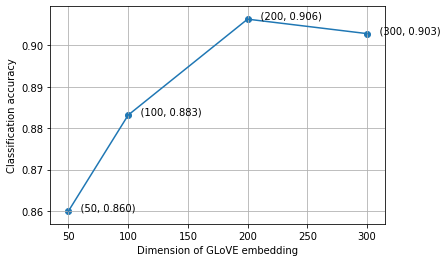

In [54]:
dims_of_glove = [50,100,200,300]
acc_scores = []

for dim in dims_of_glove: 
  # Load GLoVE embeddings
  embeddings_dict = load_glove(dim=dim)
  
  # Get GLoVE representations of input data
  XTrain_glove = features_from_glove(traindataset.data, embeddings_dict, dim)
  XTest_glove = features_from_glove(testdataset.data, embeddings_dict, dim)
  
  # Perform classification 
  SVM = LinearSVC(C=bestsvm_gamma,random_state=42,max_iter=10000)
  y_pred = SVM.fit(XTrain_glove,y_train).predict(XTest_glove) # predicting labels for soft margin SVM
  acc_scores.append(accuracy_score(y_test,y_pred))

  print(f'Dim of GLoVE: {dim}, Accuracy: {accuracy_score(y_test,y_pred)}')

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(dims_of_glove, acc_scores)
plt.scatter(dims_of_glove, acc_scores)
for xy in zip(dims_of_glove, acc_scores):                                       
    ax.annotate('    (%s, %.3f)' % xy, xy=xy, textcoords='data')
plt.xlabel('Dimension of GLoVE embedding'); plt.ylabel('Classification accuracy'); 
plt.grid()

### Question 11: GLoVE results analysis part 2 

/Users/zhiyuanchen/anaconda3/lib/python3.7/site-packages/umap/spectral.py:253: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


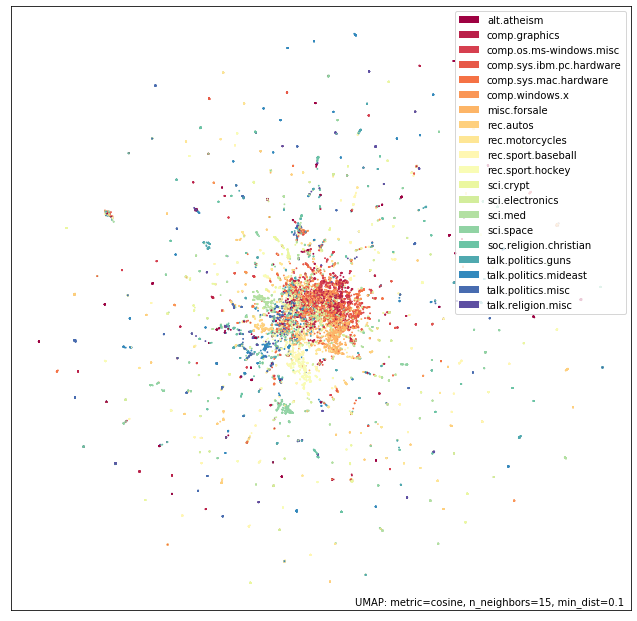

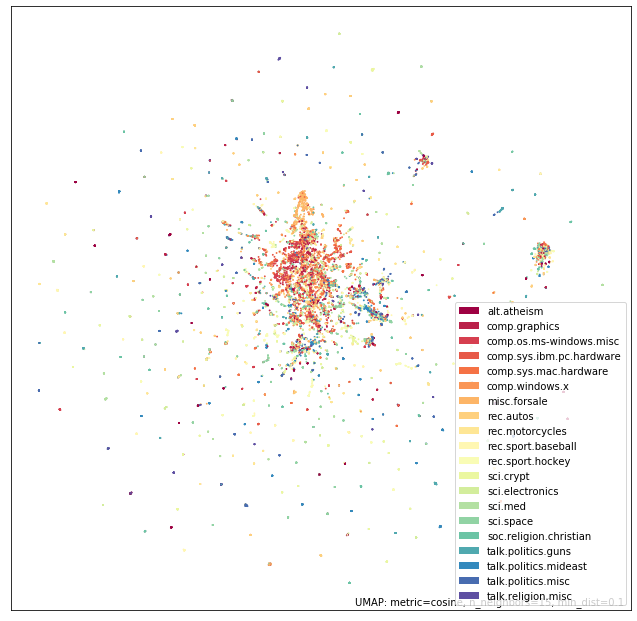

In [71]:
# Adapated code from: https://umap-learn.readthedocs.io/en/latest/document_embedding.html

import pandas as pd

import datashader as ds
import datashader.transfer_functions as tf
import datashader.bundling as bd
import matplotlib.pyplot as plt
import colorcet
import matplotlib.colors
import matplotlib.cm
import bokeh.plotting as bpl
import bokeh.transform as btr
import holoviews as hv
import holoviews.operation.datashader as hd

import umap
import umap.plot

# Get entire dataset
entire_dataset = fetch_20newsgroups(subset='all',
                             shuffle=True, random_state=42)
category_labels = [entire_dataset.target_names[x] for x in entire_dataset.target]
hover_df = pd.DataFrame(category_labels, columns=['category'])

 # Get GLoVE and random embeddings
dim_of_glove = 300
embeddings_dict = load_glove(dim=dim_of_glove)

random_embeddings_dict = {}
for word in embeddings_dict.keys(): 
  random_vec = np.random.normal(size=(dim_of_glove)) # Generate normalized random vectors 
  random_embeddings_dict[word] = random_vec / np.sqrt(np.sum(np.square(random_vec)))  

# Get embeddings representation of wrod docs
word_doc_matrix_glove = features_from_glove(entire_dataset.data, embeddings_dict, dim_of_glove)
word_doc_matrix_random = features_from_glove(entire_dataset.data, random_embeddings_dict, dim_of_glove)

# Dimensionality reduction for visualization
embedding_glove = umap.UMAP(n_components=2, metric='cosine').fit(word_doc_matrix_glove)
embedding_random = umap.UMAP(n_components=2, metric='cosine').fit(word_doc_matrix_random)

# Plot
f_glove = umap.plot.points(embedding_glove, labels=hover_df['category'])
f_random = umap.plot.points(embedding_random, labels=hover_df['category'])

## Multiclass classification

### Question 12: Multiclassification 

*   Naive Bayes
*   One vs One SVM
* One vs All SVM



In [72]:
# setup multiclassification data
categories = ['comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'misc.forsale', 'soc.religion.christian']

traindataset = fetch_20newsgroups(subset = 'train', categories = categories, shuffle = True, random_state = 42)# getting training data
traindataset = lemmatize_dataset(traindataset) # lemmatize 
y_train = traindataset.target

testdataset = fetch_20newsgroups(subset = 'test', categories = categories, shuffle = True, random_state = 42) # getting test data
testdataset = lemmatize_dataset(testdataset) # lemmatize
y_test = testdataset.target

# TF-IDF feature extraction 
tfi_vect = TfidfVectorizer(stop_words='english',min_df=3)
XTrain_tfi = tfi_vect.fit_transform(traindataset.data) # making the tfidf train matrix
XTest_tfi = tfi_vect.transform(testdataset.data) # transforming the test data into the tfidf test matrix

# Dimensionality reduction 
lsi = TruncatedSVD(n_components=50, random_state=42)
XTrain_lsi = lsi.fit_transform(XTrain_tfi) # performing LSI on the tfidf train matrix
XTest_lsi = lsi.transform(XTest_tfi) # performing LSI on the tfidf test matrix

print(f'XTrain_lsi: {XTrain_lsi.shape}, y_train: {y_train.shape}')
print(f'XTest_lsi: {XTest_lsi.shape}, y_test: {y_test.shape}')

XTrain_lsi: (2352, 50), y_train: (2352,)
XTest_lsi: (1565, 50), y_test: (1565,)


Classification Report for Gaussian Naive Bayes:
                          precision    recall  f1-score   support

comp.sys.ibm.pc.hardware       0.63      0.61      0.62       392
   comp.sys.mac.hardware       0.69      0.41      0.51       385
            misc.forsale       0.56      0.80      0.66       390
  soc.religion.christian       0.96      0.98      0.97       398

                accuracy                           0.70      1565
               macro avg       0.71      0.70      0.69      1565
            weighted avg       0.71      0.70      0.69      1565

Overall testing accuracy: 0.7009584664536741


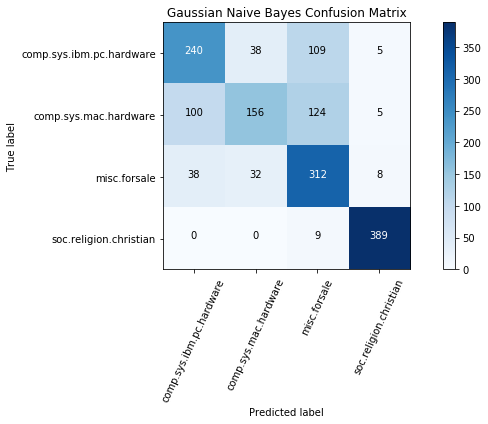

In [73]:
from sklearn.metrics import classification_report

# Naive Bayes multiclassification 
clf = GaussianNB()
ypred_nb = clf.fit(XTrain_lsi, y_train).predict(XTest_lsi) # train and predict

print('Classification Report for Gaussian Naive Bayes:')
print(classification_report(y_test,ypred_nb, target_names = testdataset.target_names))

print(f'Overall testing accuracy: {accuracy_score(y_test,ypred_nb)}')

nb_confm = confusion_matrix(y_test,ypred_nb)
plt.figure(figsize=(10,6))
plotconfusion_matrix(nb_confm, classes=testdataset.target_names, title='Gaussian Naive Bayes Confusion Matrix')

Grid search results for SVM:  {'mean_fit_time': array([0.35645342, 0.34936938, 0.22878408, 0.12821345, 0.11047058,
       0.11082182, 0.11183901]), 'std_fit_time': array([0.01567929, 0.01222636, 0.00965264, 0.00684286, 0.00870204,
       0.00360786, 0.00900234]), 'mean_score_time': array([0.05009642, 0.04932685, 0.03892059, 0.02484722, 0.02126451,
       0.0202414 , 0.01976953]), 'std_score_time': array([0.00301185, 0.00266332, 0.00266282, 0.00142269, 0.00113821,
       0.00091132, 0.00093839]), 'param_C': masked_array(data=[0.001, 0.01, 0.1, 1, 10, 100, 1000],
             mask=[False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 0.001}, {'C': 0.01}, {'C': 0.1}, {'C': 1}, {'C': 10}, {'C': 100}, {'C': 1000}], 'split0_test_score': array([0.25477707, 0.42250531, 0.86836518, 0.89171975, 0.90658174,
       0.89808917, 0.89384289]), 'split1_test_score': array([0.25477707, 0.44585987, 0.86624204, 0.89596603, 0.88110403,
       

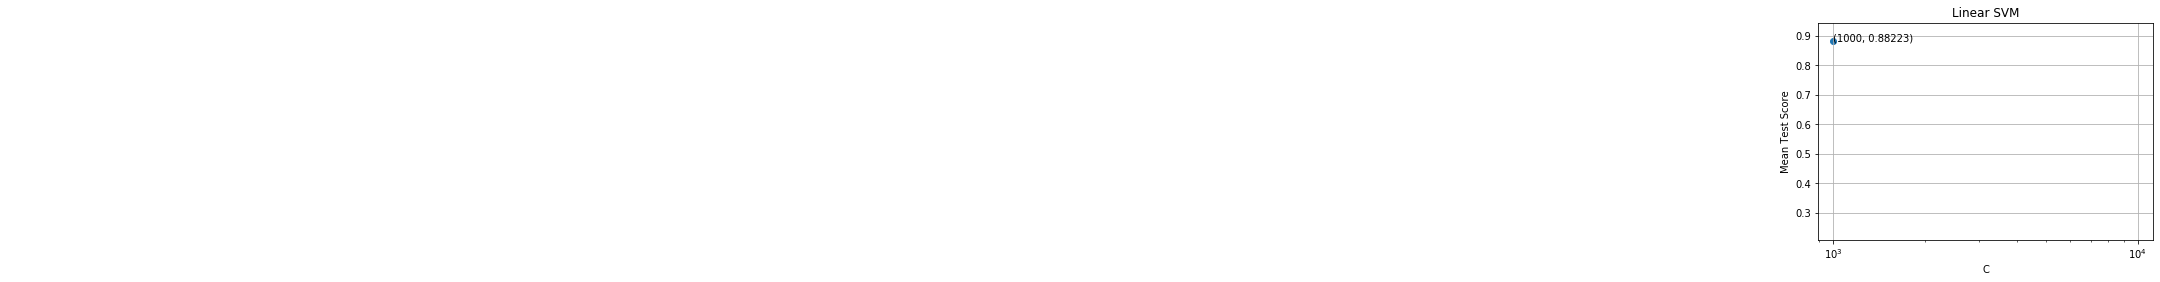

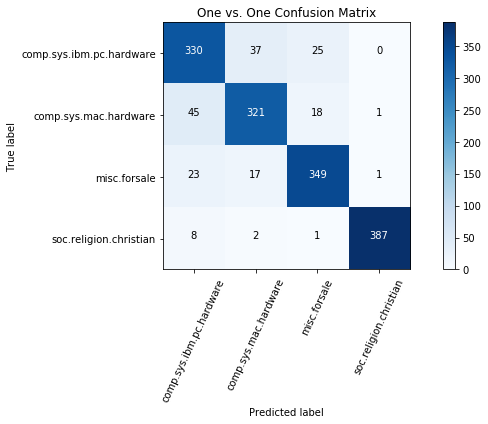

In [74]:
# One vs. One -- SVC performs One vs. One
from sklearn.svm import SVC 

# Grid search params
params_list = [0.001,0.01,0.1,1,10,100,1000]
params = {'C':[0.001,0.01,0.1,1,10,100,1000]}

# initalize and train using grid search 
svc = SVC(random_state=42, max_iter=10000)
crof = GridSearchCV(svc,params,cv=5,scoring='accuracy') # Finding the best gamma using cross validation
crof.fit(XTrain_lsi,y_train)

# results of grid search
y = crof.cv_results_['mean_test_score']
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(x,y)
for xy in zip(x, y):                                       
    ax.annotate('(%s, %.5f)' % xy, xy=xy, textcoords='data')
plt.xlabel('C')
plt.ylabel('Mean Test Score')
plt.title("Linear SVM")
plt.grid()
ax.set_xscale('log')

# predictions using best hyperparams
ypred_cv = crof.best_estimator_.predict(XTest_lsi)
bestsvm_gamma = crof.best_estimator_.C

print("Grid search results for SVM: ", crof.cv_results_)
print("Best estimator for SVM: ", crof.best_estimator_)
print("Best parameters for SVM: ", crof.best_params_)
print("Best score for SVM: ", crof.best_score_)
print("Best Gamma for SVM: ", bestsvm_gamma)

# Classification metrics 
print('Classification Report for One vs One SVM:')
print(classification_report(y_test,ypred_cv,target_names=testdataset.target_names))

print(f'Overall testing accuracy: {accuracy_score(y_test,ypred_cv)}')

cv_confm = confusion_matrix(y_test,ypred_cv) # Best Gamma SVM confusion matrix
plt.figure(figsize=(10,6))
plotconfusion_matrix(cv_confm, classes=testdataset.target_names, title='One vs. One Confusion Matrix')

/Users/zhiyuanchen/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/zhiyuanchen/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/zhiyuanchen/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/zhiyuanchen/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/zhiyuanchen/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to c

Grid search results for SVM:  {'mean_fit_time': array([0.01418629, 0.01078539, 0.01541739, 0.02647324, 0.1193584 ,
       0.99662895, 2.84671288]), 'std_fit_time': array([0.00067007, 0.00044289, 0.00037144, 0.0017572 , 0.01098879,
       0.10782554, 0.20593987]), 'mean_score_time': array([0.0004621 , 0.00047297, 0.00049891, 0.00043688, 0.00046825,
       0.00050726, 0.00077395]), 'std_score_time': array([5.58081622e-05, 4.60258777e-05, 4.48482015e-05, 2.59482672e-05,
       6.31752551e-05, 4.11523452e-05, 7.06038532e-05]), 'param_C': masked_array(data=[0.001, 0.01, 0.1, 1, 10, 100, 1000],
             mask=[False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 0.001}, {'C': 0.01}, {'C': 0.1}, {'C': 1}, {'C': 10}, {'C': 100}, {'C': 1000}], 'split0_test_score': array([0.83227176, 0.87261146, 0.88747346, 0.90021231, 0.9044586 ,
       0.89808917, 0.89596603]), 'split1_test_score': array([0.81528662, 0.87048832, 0.87685775, 0.8

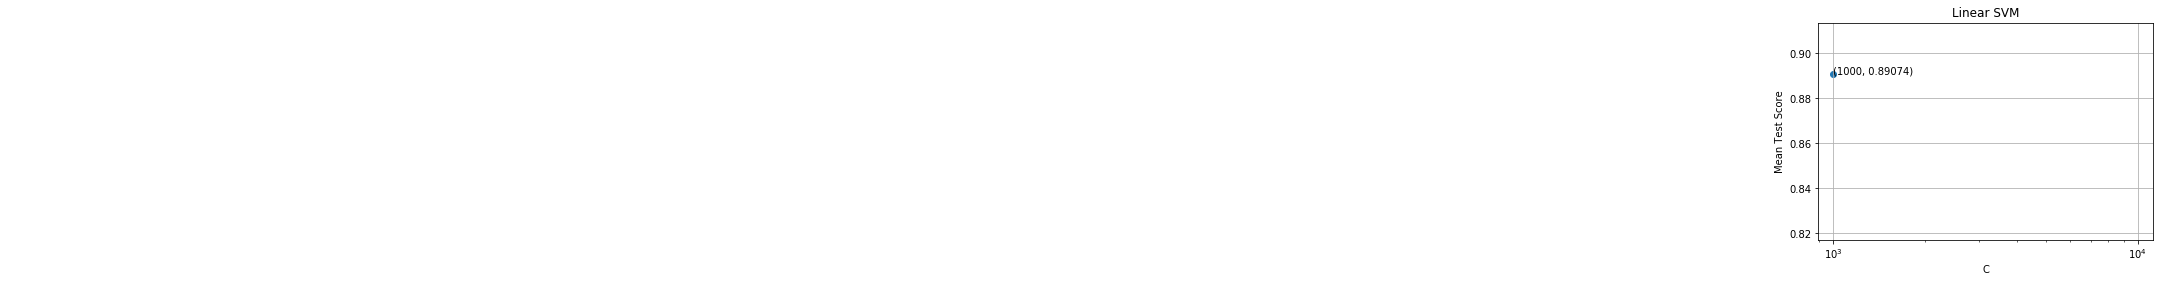

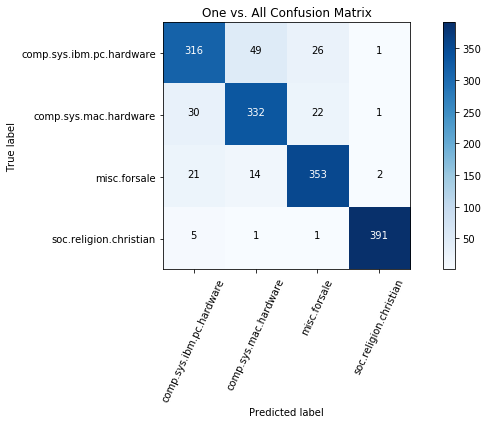

In [75]:
# One vs. all -- LinearSVC performs One vs. All
from sklearn.svm import LinearSVC 

# Grid search params
params_list = [0.001,0.01,0.1,1,10,100,1000]
params = {'C':[0.001,0.01,0.1,1,10,100,1000]}

# initalize and train using grid search 
lsvc = LinearSVC(random_state=42,max_iter=10000) 
crof = GridSearchCV(lsvc,params,cv=5,scoring='accuracy') # Finding the best gamma using cross validation
crof.fit(XTrain_lsi,y_train)

# results of grid search
y = crof.cv_results_['mean_test_score']
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(x,y)
for xy in zip(x, y):                                       
    ax.annotate('(%s, %.5f)' % xy, xy=xy, textcoords='data')
plt.xlabel('C')
plt.ylabel('Mean Test Score')
plt.title("Linear SVM")
plt.grid()
ax.set_xscale('log')

# predictions using best hyperparams
ypred_cv = crof.best_estimator_.predict(XTest_lsi)
bestsvm_gamma = crof.best_estimator_.C

print("Grid search results for SVM: ", crof.cv_results_)
print("Best estimator for SVM: ", crof.best_estimator_)
print("Best parameters for SVM: ", crof.best_params_)
print("Best score for SVM: ", crof.best_score_)
print("Best Gamma for SVM: ", bestsvm_gamma)

# Classification metrics 
print('Classification Report for One vs All SVM:')
print(classification_report(y_test,ypred_cv,target_names=testdataset.target_names))

print(f'Overall testing accuracy: {accuracy_score(y_test,ypred_cv)}')

cv_confm = confusion_matrix(y_test,ypred_cv) # Best Gamma SVM confusion matrix
plt.figure(figsize=(10,6))
plotconfusion_matrix(cv_confm, classes=testdataset.target_names, title='One vs. All Confusion Matrix')